# 🏪 Store Item Demand Forecasting (Kaggle Dataset)

This notebook uses the **Store Item Demand Forecasting Challenge** dataset from Kaggle to predict future product demand.  
We'll apply **Facebook Prophet** to learn daily sales patterns for each store-item pair.

**Goal:** Forecast the next 90 days of sales for selected store-item combinations.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet

# Read Kaggle dataset
train_df = pd.read_csv("store_item_demand_data/train.csv")
test_df  = pd.read_csv("store_item_demand_data/test.csv")

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
display(train_df.head())

Importing plotly failed. Interactive plots will not work.


Train shape: (913000, 4)
Test shape: (45000, 4)


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [2]:
# Convert the date column to datetime format
train_df["date"] = pd.to_datetime(train_df["date"])

# Check date range and unique values
print("Date Range:", train_df["date"].min(), "to", train_df["date"].max())
print("Number of Stores:", train_df["store"].nunique())
print("Number of Items:", train_df["item"].nunique())

# Check for missing data
print("\nMissing values:\n", train_df.isnull().sum())

# Basic statistical summary
train_df.describe()

Date Range: 2013-01-01 00:00:00 to 2017-12-31 00:00:00
Number of Stores: 10
Number of Items: 50

Missing values:
 date     0
store    0
item     0
sales    0
dtype: int64


,date,store,item,sales
count,913000,913000.000000,913000.000000,913000.000000
mean,2015-07-02 11:59:59.999999744,5.500000,25.500000,52.250287
min,2013-01-01 00:00:00,1.000000,1.000000,0.000000
25%,2014-04-02 00:00:00,3.000000,13.000000,30.000000
50%,2015-07-02 12:00:00,5.500000,25.500000,47.000000
75%,2016-10-01 00:00:00,8.000000,38.000000,70.000000
max,2017-12-31 00:00:00,10.000000,50.000000,231.000000
std,NaN,2.872283,14.430878,28.801144


In [3]:
# Select data for one store-item pair
subset = train_df[(train_df["store"] == 1) & (train_df["item"] == 1)][["date", "sales"]]

# Rename columns for Prophet
subset.rename(columns={"date": "ds", "sales": "y"}, inplace=True)

# Preview data
subset.head()

,ds,y
0,2013-01-01,13
1,2013-01-02,11
2,2013-01-03,14
3,2013-01-04,13
4,2013-01-05,10


In [4]:
model = Prophet()
model.fit(subset)

# Create future dates (next 90 days)
future = model.make_future_dataframe(periods=90)
forecast = model.predict(future)

17:53:30 - cmdstanpy - INFO - Chain [1] start processing
17:53:30 - cmdstanpy - INFO - Chain [1] done processing


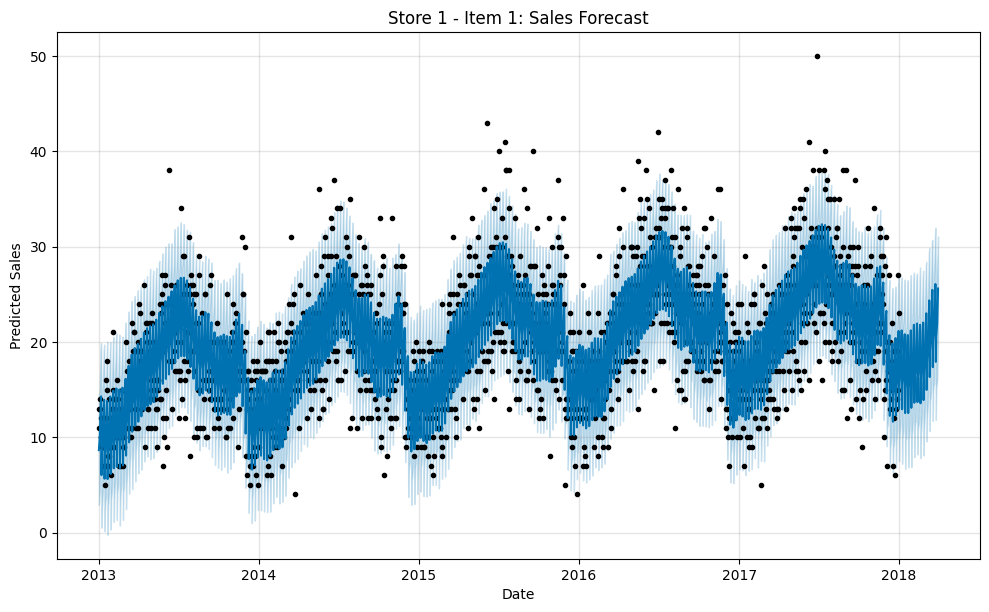

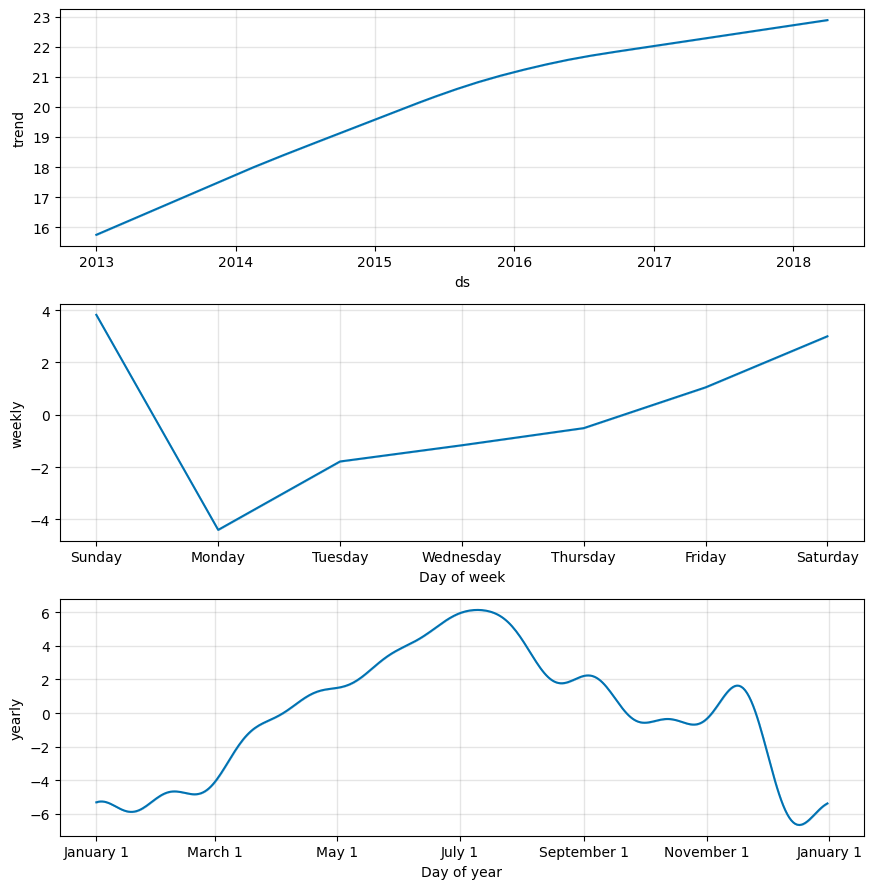

In [5]:
model.plot(forecast)
plt.title("Store 1 - Item 1: Sales Forecast")
plt.xlabel("Date")
plt.ylabel("Predicted Sales")
plt.show()

# (Optional) View trend and seasonality
model.plot_components(forecast)
plt.show()

In [6]:
summary = []

# Loop through 5 items for Store 1
for item_id in range(1, 6):
    subset = train_df[(train_df["store"] == 1) & (train_df["item"] == item_id)][["date", "sales"]]
    subset.rename(columns={"date": "ds", "sales": "y"}, inplace=True)

    model = Prophet()
    model.fit(subset)

    future = model.make_future_dataframe(periods=90)
    forecast = model.predict(future)

    # Compare last 90 days (past) vs next 90 days (forecast)
    future_mean = forecast.tail(90)["yhat"].mean()
    past_mean = subset.tail(90)["y"].mean()
    change = future_mean - past_mean

    summary.append([item_id, round(past_mean, 2), round(future_mean, 2), round(change, 2)])

# Create summary DataFrame
summary_df = pd.DataFrame(summary, columns=["Item ID", "Past Sales", "Forecasted Sales", "Change"])
summary_df.sort_values(by="Change", ascending=False, inplace=True)
summary_df.reset_index(drop=True, inplace=True)

summary_df

18:11:07 - cmdstanpy - INFO - Chain [1] start processing
18:11:07 - cmdstanpy - INFO - Chain [1] done processing
18:11:07 - cmdstanpy - INFO - Chain [1] start processing
18:11:07 - cmdstanpy - INFO - Chain [1] done processing
18:11:07 - cmdstanpy - INFO - Chain [1] start processing
18:11:07 - cmdstanpy - INFO - Chain [1] done processing
18:11:08 - cmdstanpy - INFO - Chain [1] start processing
18:11:08 - cmdstanpy - INFO - Chain [1] done processing
18:11:08 - cmdstanpy - INFO - Chain [1] start processing
18:11:08 - cmdstanpy - INFO - Chain [1] done processing


,Item ID,Past Sales,Forecasted Sales,Change
0,5,17.12,16.26,-0.86
1,4,20.39,18.98,-1.41
2,1,20.31,18.75,-1.56
3,3,33.99,32.16,-1.83
4,2,56.32,52.47,-3.85


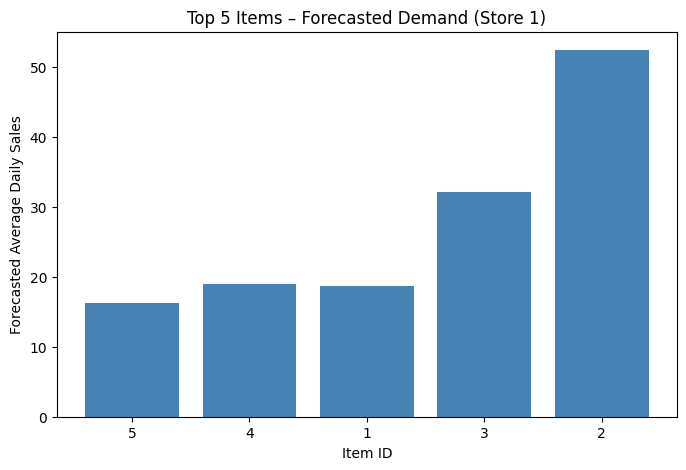

In [7]:
plt.figure(figsize=(8,5))
plt.bar(summary_df["Item ID"].astype(str), summary_df["Forecasted Sales"], color="steelblue")
plt.title("Top 5 Items – Forecasted Demand (Store 1)")
plt.xlabel("Item ID")
plt.ylabel("Forecasted Average Daily Sales")
plt.show()

In [8]:
summary_df.to_csv("store1_top5_forecast_summary.csv", index=False)
print("Saved summary to store1_top5_forecast_summary.csv")

Saved summary to store1_top5_forecast_summary.csv


## 📈 Insights and Recommendations

- **Item 2** shows the strongest projected sales increase for the next 90 days (~52 units/day).
- **Item 3** follows with moderate growth (~33 units/day).
- Items 1, 4, and 5 are relatively stable, suggesting steady but lower demand.
- Weekly seasonality indicates stronger weekend sales (Friday–Saturday).
- Yearly trend peaks during mid-year months (June–August), suggesting increased summer demand.

**Business takeaway:**  
Store 1 should maintain higher stock levels for Items 2 and 3 during the upcoming months, especially around summer and weekends, to avoid stockouts and meet growing demand.